In [ ]:
import pandas as pd
from google.colab import drive
import tensorflow
from  tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from keras.models import Model
from keras.optimizers import SGD
import tensorflow as tf
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn import metrics

drive.mount('/content/drive/')
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Pulmonary Fibrosis/results/results_sample_data.csv")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:

df.Class = df.Class.astype(str)
datagen = ImageDataGenerator()

target_size=(128,128)

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Create separate data generators for training and validation
train_data_generator = ImageDataGenerator(
    # Your data augmentation and preprocessing parameters here
).flow_from_dataframe(
    dataframe=train_df,
    x_col="Image_path",
    y_col="Class",
    batch_size=64,
    seed=42,
    class_mode='sparse',
    shuffle=True,
    target_size=target_size,
)

val_data_generator = ImageDataGenerator().flow_from_dataframe(
    dataframe=val_df,
    x_col="Image_path",
    y_col="Class",
    batch_size=64,
    seed=42,
    class_mode='sparse',
    shuffle=False,  # No need to shuffle validation data
    target_size=target_size,
)


Found 4236 validated image filenames belonging to 5 classes.
Found 1059 validated image filenames belonging to 5 classes.


In [ ]:
base_model=tf.keras.applications.efficientnet_v2.EfficientNetV2L(weights='imagenet',include_top=False, input_shape=(128, 128, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation = 'relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(5, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=SGD(lr=0.1, momentum=0.9), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')

history = model.fit(train_data_generator,
                    steps_per_epoch=4236   //64,
                    epochs = 20,
                    validation_data=val_data_generator,
                    validation_steps= 1059 // 64,
                    callbacks = [callback])

473176280/473176280 [==============================] - 3s 0us/step


Epoch 1/20
66/66 [==============================] - 1971s 28s/step - loss: 0.8793 - accuracy: 0.6302 - val_loss: 0.3257 - val_accuracy: 0.8633
Epoch 2/20
66/66 [==============================] - 72s 1s/step - loss: 0.3250 - accuracy: 0.8651 - val_loss: 0.3177 - val_accuracy: 0.8682
Epoch 3/20
66/66 [==============================] - 75s 1s/step - loss: 0.2385 - accuracy: 0.8967 - val_loss: 0.2417 - val_accuracy: 0.9160
Epoch 4/20
66/66 [==============================] - 75s 1s/step - loss: 0.1969 - accuracy: 0.9173 - val_loss: 0.1819 - val_accuracy: 0.9238
Epoch 5/20
66/66 [==============================] - 76s 1s/step - loss: 0.1702 - accuracy: 0.9235 - val_loss: 0.2203 - val_accuracy: 0.9141
Epoch 6/20
66/66 [==============================] - 75s 1s/step - loss: 0.1581 - accuracy: 0.9343 - val_loss: 0.1796 - val_accuracy: 0.9346
Epoch 7/20
66/66 [==============================] - 78s 1s/step - loss: 0.1603 - accuracy: 0.9281 - val_loss: 0.1973 - val_accuracy: 0.9307
Epoch 8/20
66/66 

<ipython-input-5-55f5fac8f79b>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = model.predict_generator(val_data_generator, 1059 // 64+1)


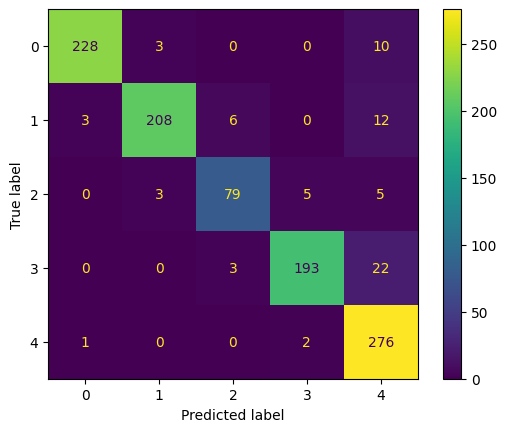

In [ ]:
y_pred = model.predict_generator(val_data_generator, 1059 // 64+1)
Y_pred = np.argmax(y_pred, axis=1)


confusion_matrix = confusion_matrix(val_data_generator.classes, Y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)

cm_display.plot()
plt.show()

In [ ]:
print(classification_report(val_data_generator.classes, Y_pred))

              precision    recall  f1-score   support

           0       0.98      0.95      0.96       241
           1       0.97      0.91      0.94       229
           2       0.90      0.86      0.88        92
           3       0.96      0.89      0.92       218
           4       0.85      0.99      0.91       279

    accuracy                           0.93      1059
   macro avg       0.93      0.92      0.92      1059
weighted avg       0.93      0.93      0.93      1059



In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(val_data_generator.classes, Y_pred)

0.9291784702549575